In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=af29b9ec1c73782b1c6bec7196c64ae607f0331931c2cdbe1fb9c65ec1c24a0e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import math
import torch
from torch import nn
import transformers
from transformers import BertTokenizer
from transformers import AdamW, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import os
import pandas as pd
import random
import numpy as np

import time
import datetime

import sys
from google.colab import drive

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/COSE474/1')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/COSE474/1
!cd /content/drive/MyDrive/COSE474/1
!wget -P /content/drive/MyDrive/COSE474/1/data/ https://raw.githubusercontent.com/uSafeSpot/COSE474-finalproj/main/data/data.csv

mkdir: cannot create directory ‘/content/drive/MyDrive/COSE474/1’: File exists
--2023-12-09 04:13:31--  https://raw.githubusercontent.com/uSafeSpot/COSE474-finalproj/main/data/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14685151 (14M) [text/plain]
Saving to: ‘/content/drive/MyDrive/COSE474/1/data/data.csv.10’

data.csv.10         100%[===================>]  14.00M  80.8MB/s    in 0.2s    

2023-12-09 04:13:32 (80.8 MB/s) - ‘/content/drive/MyDrive/COSE474/1/data/data.csv.10’ saved [14685151/14685151]



In [ ]:
!cd /content/drive/MyDrive/COSE474/1/data

In [ ]:
ls /content/drive/MyDrive/COSE474/1/data

data.csv  data.csv.1  data.csv.2  data.csvfp0ogzx7.tmp  data.csvjyjmdrlx.tmp  data.csvou9201h4.tmp


## Preprocessing

In [ ]:
url = 'https://raw.githubusercontent.com/uSafeSpot/COSE474-finalproj/main/data/data.csv'

path = '/content/drive/MyDrive/COSE474/1/data/data.csv'
save_path = '/content/drive/MyDrive/COSE474/2/model'

DATA_CLIP = 0

df = pd.read_csv(path, delimiter=',', header=0)

print(f'length(data): {df.shape[0]}')
print(df.sample(3))

DATA_CLIP = df.shape[0] if not DATA_CLIP else DATA_CLIP

statements = df.problem_statement[0:DATA_CLIP]
tags = df.problem_tags[0:DATA_CLIP]

tag_cnt = dict()

i = 0
for tag in tags:
    tag = tag.split(',')
    for t in tag:
        if(not t.startswith('*')):
            if(t in tag_cnt):
                tag_cnt[t] += 1
            else:
                tag_cnt[t] = 1
    i += 1

tag_list = list()

print(tag_cnt)

for k, v in tag_cnt.items():
    tag_list.append((v, k))
tag_list.sort()
tag_list.reverse()

tag_dict = dict([(tag_list[i][1], i) for i in range(20)])
tag_vectors = []
tag_dim = len(tag_dict)
for tag in tags:
    tag = tag.split(',')
    tagvec = torch.zeros(tag_dim)
    for t in tag:
        if(t in tag_dict):
            tagvec[tag_dict[t]] = 1
    tag_vectors.append(tagvec)

tag_vectors = torch.stack(tag_vectors)

print(f"tag space dimension: {tag_dim}")
print(tag_dict)
print(tag_list)

tk = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized = []
att_masks = []

for stm in statements:
    encoded = tk.encode_plus(
        stm,
        add_special_tokens = True,
        max_length = 512,
        pad_to_max_length=True,
        truncation=True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    tokenized.append(encoded['input_ids'])
    att_masks.append(encoded['attention_mask'])

tokenized = torch.stack(tokenized)
att_masks = torch.stack(att_masks)

length(data): 8234
      contest problem_name                                  problem_statement  \
2521      667            B  As some of you know, cubism is a trend in art,...   
3966      782            B  The main road in Bytecity is a straight line f...   
7193      928            D  Arcady is a copywriter. His today's task is to...   

                               problem_tags  
2521  constructivealgorithms,geometry,*1100  
3966       binarysearch,ternarysearch,*1600  
7193    *specialproblem,strings,trees,*1900  
{'implementation': 2219, 'binarysearch': 785, 'math': 2027, 'dfsandsimilar': 718, 'graphs': 901, 'shortestpaths': 220, 'dsu': 247, 'combinatorics': 460, 'greedy': 1949, 'geometry': 343, 'dp': 1672, 'numbertheory': 553, 'constructivealgorithms': 1180, 'strings': 572, 'datastructures': 1288, 'sortings': 759, 'trees': 617, 'divideandconquer': 189, 'bruteforce': 1172, 'hashing': 160, 'bitmasks': 348, 'twopointers': 361, 'meet-in-the-middle': 36, 'interactive': 144, '2-sat

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
batch_size = 8
epochs = 6
dropout_p = 0.5
learning_rate = 5e-6

with_gpu = True

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("cuda")
else:
    device = torch.device("cpu")
    with_gpu = False
    print('cpu')

dataset = TensorDataset(tokenized, att_masks, tag_vectors)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

classifier = nn.Linear(768, tag_dim)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = tag_dim,
    output_attentions = False,
    output_hidden_states = False,
    return_dict=False,
    problem_type = 'multi_label_classification',
    classifier_dropout = dropout_p
)

if(with_gpu):
    model.cuda()
else:
    model.cpu()

optimizer = AdamW(model.parameters(),
              lr = learning_rate,
              eps = 1e-8
            )

total_steps = len(train_dataloader) * epochs

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

seed_val = 1

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('[Training]')

    t0 = time.time()

    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].squeeze(1).to(device)
        b_input_mask = batch[1].squeeze(1).to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        (loss, logits) = model(input_ids=b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("[Running Validation]")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    f1_thr = torch.zeros([100])

    s_TP_thr = torch.zeros([100, tag_dim])
    s_FP_thr = torch.zeros([100, tag_dim])
    s_FN_thr = torch.zeros([100, tag_dim])
    hamming_thr = torch.zeros([100])

    for batch in validation_dataloader:
        b_input_ids = batch[0].squeeze(1).to(device)
        b_input_mask = batch[1].squeeze(1).to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            (loss, logits) = model(input_ids=b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().squeeze(0)
        labels = b_labels.cpu().type('torch.LongTensor')

        preds = nn.Sigmoid()(logits)

        for _thr in range(100):
            thr = _thr / 100
            preds_b = preds > thr
            s_TP_thr[_thr] += torch.sum(preds_b & labels, dim=0)
            s_FP_thr[_thr] += torch.sum(preds_b & (1-labels), dim=0)
            s_FN_thr[_thr] += torch.sum(labels & ~preds_b, dim=0)
            hamming_thr[_thr] += torch.sum(labels ^ preds_b, dim=(0, 1)) / labels.numel()


    prec = s_TP_thr / (s_TP_thr + s_FP_thr)
    recl = s_TP_thr / (s_TP_thr + s_FN_thr)

    f1_thr = 2 * prec * recl / (prec + recl)

    val_f1_thr = torch.nan_to_num(torch.mean(f1_thr, dim=1), nan=-float('inf'))
    val_f1 = torch.max(val_f1_thr)
    max_thres = torch.argmax(val_f1_thr)

    print("  F1: {0:.2f}".format(val_f1*100))
    print("  threshold: {0:.4f}".format(max_thres/ 100))
    print("  P: {0:.4f}".format(torch.mean(prec[max_thres])))
    print("  R: {0:.4f}".format(torch.mean(recl[max_thres])))
    print("  Hamming Loss: {0: .4f}".format(hamming_thr[max_thres] / len(validation_dataloader)))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1.': val_f1,
            'Valid. argmax thres.': max_thres,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

model.save_pretrained(save_path)

print("Training saved!")

cuda
7,410 training samples
  824 validation samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



======== Epoch 1 / 6 ========
[Training]
  Batch    40  of    927.    Elapsed: 0:00:10.
  Batch    80  of    927.    Elapsed: 0:00:20.
  Batch   120  of    927.    Elapsed: 0:00:29.
  Batch   160  of    927.    Elapsed: 0:00:39.
  Batch   200  of    927.    Elapsed: 0:00:49.
  Batch   240  of    927.    Elapsed: 0:00:59.
  Batch   280  of    927.    Elapsed: 0:01:09.
  Batch   320  of    927.    Elapsed: 0:01:19.
  Batch   360  of    927.    Elapsed: 0:01:29.
  Batch   400  of    927.    Elapsed: 0:01:39.
  Batch   440  of    927.    Elapsed: 0:01:48.
  Batch   480  of    927.    Elapsed: 0:01:58.
  Batch   520  of    927.    Elapsed: 0:02:08.
  Batch   560  of    927.    Elapsed: 0:02:18.
  Batch   600  of    927.    Elapsed: 0:02:28.
  Batch   640  of    927.    Elapsed: 0:02:38.
  Batch   680  of    927.    Elapsed: 0:02:48.
  Batch   720  of    927.    Elapsed: 0:02:58.
  Batch   760  of    927.    Elapsed: 0:03:08.
  Batch   800  of    927.    Elapsed: 0:03:17.
  Batch   840  of 

In [ ]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. F1.,Valid. argmax thres.,Training Time,Validation Time
epoch,,,,,,
1,0.374882,0.322340,tensor(0.2185),tensor(7),0:03:49,0:00:09
2,0.318285,0.307836,tensor(0.2510),tensor(7),0:03:49,0:00:09
3,0.304303,0.298812,tensor(0.2619),tensor(6),0:03:49,0:00:09
4,0.295127,0.293617,tensor(0.3017),tensor(9),0:03:49,0:00:09
5,0.288985,0.291714,tensor(0.2967),tensor(8),0:03:49,0:00:09
6,0.287286,0.291016,tensor(0.2940),tensor(8),0:03:49,0:00:09


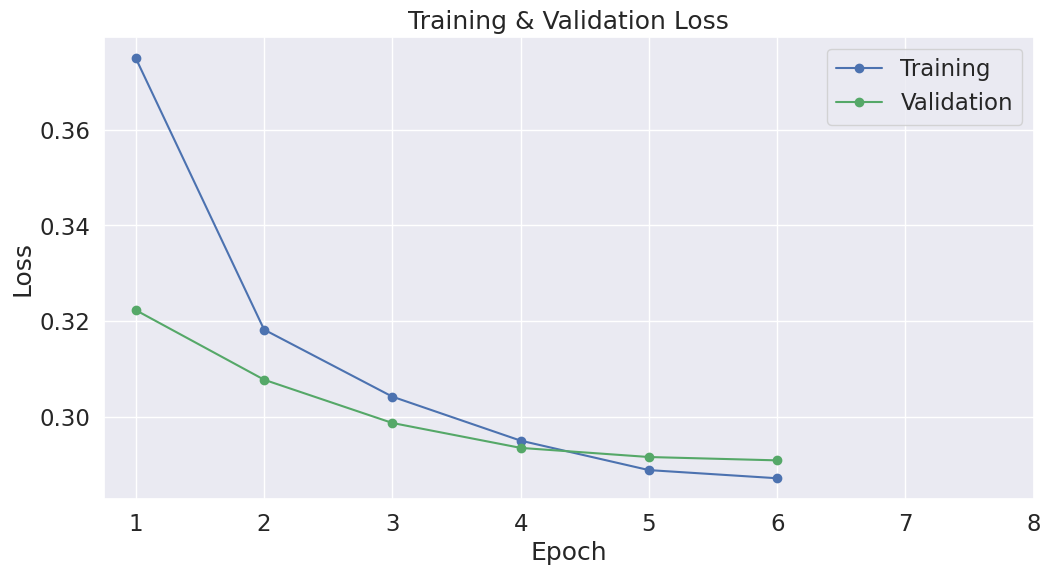

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8])

plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained(save_path)
print(model)

model.to('cuda')

statement = input()

tk = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encoded = tk.encode_plus(
    statement,
    add_special_tokens = True,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    return_attention_mask = True,
    return_tensors = 'pt'
)
print(tk.decode(encoded['input_ids'][0]))

model.eval()
(loss, logits) = model(input_ids=encoded['input_ids'].to('cuda'),
                  token_type_ids=None,
                  attention_mask=encoded['attention_mask'].to('cuda'),
                  labels=torch.zeros([1, tag_dim]).to('cuda'))

print(logits)

print(torch.nn.Sigmoid()(logits)[0])
max_thres = 0.08
pred = torch.nn.Sigmoid()(logits)[0] > max_thres
pred = pred.cpu()
for i in range(tag_dim):
    if(pred[i]): print(tag_list[i][1])

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
